# Analysis for Differential Jet Mass in Z+Jets events with NanoAODv9

In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle

import traceback
import dask
#from distributed.diagnostics.plugin import UploadDirectory
import os 



#from cms_utils import *
print("numpy version", np.__version__)
print("dask version", dask.__version__)

awkward version  1.10.3
coffea version  0.7.22
numpy version 1.23.5
dask version 2023.3.1


### Automatically reload any modules used

In [2]:
hist.axis.Regular(100,0,200, name="mgen", label=r"Mass (GeV)").edges

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200.])

In [3]:
casa = False
enable_dask = 1

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:

from python.response_maker_nanov9_lib_v3 import *
from python.response_maker_nanov9 import *
from python.smp_utils import *
from python.cms_utils import *

In [6]:
#f = uproot.open("root://xcache//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root")

In [7]:
#f["Events"].keys()

In [8]:
# from dask.distributed import Client

# client = Client("tls://192.168.86.46:8786")
# client

# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True))
# #print(client.run(os.listdir, "dask-worker-space") )
# client.scheduler_info()['workers']

In [9]:
if enable_dask:

    if not casa:
        from distributed import Client
        from lpcjobqueue import LPCCondorCluster
        
        cluster = LPCCondorCluster(transfer_input_files = [ "correctionFiles", "samples", "python"], 
                                   ship_env = False,
                                   memory = "4GB",
                                   #cores = 2,
                                  scheduler_options={"dashboard_address": ":2018"})
        cluster.adapt(minimum=1, maximum=600)
        
        
        client = Client(cluster)
        client
    else:
        from distributed import Client
        from coffea_casa import CoffeaCasaCluster
    
        cluster = CoffeaCasaCluster(job_extra = {'transfer_input_files':[ "correctionFiles", "samples", "python"] }, memory="10 GiB")
        cluster.adapt(minimum=4, maximum=70)
        client = Client(cluster)

In [10]:
if enable_dask:
    client

In [11]:
# client.register_worker_plugin(UploadDirectory("/home/ZJet/QJetMassUproot/", restart=True, update_path=True), nanny=True)
# #print(client.run(os.listdir, "dask-worker-space") )

### If desired, uncomment these to move or remove old pkl files

In [12]:
#! mv qjetmass_zjets_gen.pkl qjetmass_zjets_gen_old.pkl
#! mv qjetmass_zjets_reco.pkl qjetmass_zjets_reco_old.pkl

In [13]:
# client.scheduler_info()['workers']

### If you want to rerun, here is the line. Otherwise keep it commented to just read the pkl file. 

In [14]:
#client = Client(cluster)
#print(client.run(os.listdir) )
#client.scheduler_info()['workers']

In [15]:


# eras_mc = ['UL16NanoAODv9']
# for era in eras_mc:
#     response_maker_nanov9(testing=False, do_gen=True, client=client, prependstr="root://cmsxrootd.fnal.gov/", eras_mc=[era], jet_syst = 'nominal', dask = True)
#     #response_maker_nanov9(testing=False, do_gen=False, client=client)
#     print("Done running 2016")
    

In [16]:

jet_systematics = ['nominal', 'JERUp', 'JERDown', 'hem',
 'JES_AbsoluteMPFBiasUp', 'JES_AbsoluteMPFBiasDown', 'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', 
 'JES_AbsoluteStatUp', 'JES_AbsoluteStatDown', 'JES_FlavorQCDUp', 'JES_FlavorQCDDown', 'JES_FragmentationUp', 
 'JES_FragmentationDown', 'JES_PileUpDataMCUp', 'JES_PileUpDataMCDown', 'JES_PileUpPtBBUp', 'JES_PileUpPtBBDown', 
 'JES_PileUpPtEC1Up', 'JES_PileUpPtEC1Down', 'JES_PileUpPtEC2Up', 'JES_PileUpPtEC2Down', 'JES_PileUpPtHFUp', 'JES_PileUpPtHFDown', 
 'JES_PileUpPtRefUp', 'JES_PileUpPtRefDown', 'JES_RelativeFSRUp', 'JES_RelativeFSRDown', 'JES_RelativeJEREC1Up', 'JES_RelativeJEREC1Down',
 'JES_RelativeJEREC2Up', 'JES_RelativeJEREC2Down', 'JES_RelativeJERHFUp', 'JES_RelativeJERHFDown', 'JES_RelativePtBBUp', 'JES_RelativePtBBDown',
 'JES_RelativePtEC1Up', 'JES_RelativePtEC1Down', 'JES_RelativePtEC2Up', 
 'JES_RelativePtEC2Down', 'JES_RelativePtHFUp', 'JES_RelativePtHFDown', 'JES_RelativeBalUp', 
 'JES_RelativeBalDown', 'JES_RelativeSampleUp', 'JES_RelativeSampleDown', 'JES_RelativeStatECUp', 'JES_RelativeStatECDown',
 'JES_RelativeStatFSRUp', 'JES_RelativeStatFSRDown', 'JES_RelativeStatHFUp', 'JES_RelativeStatHFDown', 'JES_SinglePionECALUp', 'JES_SinglePionECALDown', 
 'JES_SinglePionHCALUp', 'JES_SinglePionHCALDown', 'JES_TimePtEtaUp', 'JES_TimePtEtaDown', 'JMRUp', 'JMRDown', 'JMSUp', 'JMSDown']

systematics = ['nominal', 'puUp', 'puDown' , 'elerecoUp', 'elerecoDown', 
                                'eleidUp', 'eleidDown', 'eletrigUp', 'eletrigDown', 'murecoUp', 'murecoDown', 
                                'muidUp', 'muidDown', 'mutrigUp', 'mutrigDown', 
                                'pdfUp', 'pdfDown', 'q2Up', 'q2Down',
                                'prefiringUp', 'prefiringDown'] 

In [17]:

# jet_systematics = ['nominal',  'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown', "JERUp", "JERDown"]

# systematics = ['nominal', 'puUp'] 

In [18]:
import warnings

dask = enable_dask
eras_mc =  ['UL16NanoAODv9', 'UL16NanoAODAPVv9', 'UL17NanoAODv9','UL18NanoAODv9']
#eras_mc =  [ 'UL16NanoAODv9',  'UL16NanoAODAPVv9']
if not dask:
    client_1 = None
else:
    client_1 = client
    
#client= None

with warnings.catch_warnings():
    
    
    warnings.simplefilter("ignore")
    for era in eras_mc:
        era = era
    try:

        response_maker_nanov9(testing = False, 
                              do_gen = True,
                              client=client_1,
                              prependstr="root://cmsxrootd.fnal.gov/", 
                              eras_mc=eras_mc,
                              do_syst = True, 
                              do_jk = False,  
                              dask = dask, 
                              do_herwig = False,
                              do_background = False,
                              syst_list = systematics,
                              jet_syst_list = jet_systematics,
                              fname_out = 'outputs/pythia_syst_0302.pkl')
        #response_maker_nanov9(testing=False, do_gen=False, client=client)
        print("Done running All")
    except Exception as e:
        with open("error_log.txt", "w") as f:
            f.write("An error occurred:\n")
            f.write(str(e) + "\n\n")
            f.write("Traceback:\n")
            traceback.print_exc(file=f)



Chunk Size  400000
Max chunks None
Running over PYTHIA MC
Running...
Done running#############################] | 100% Completed | 24min 34.0s
outputs/pythia_syst_0302.pkl  was created.
Done running All


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [19]:
output['response_matrix_u']

NameError: name 'output' is not defined

In [7]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/pythia_18_2GeVbin_test.pkl'
filename2 = 'outputs/data_18.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

with open(filename2, 'rb') as f:
    output2 = pickle.load(f)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f46904b9300>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

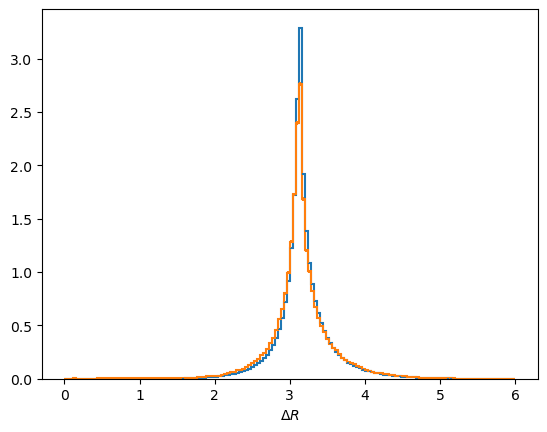

In [8]:
output1['dr_z_jet_reco'].project('dr').plot(density = 1)
output2['dr_z_jet_reco'].project('dr').plot(density = 1)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

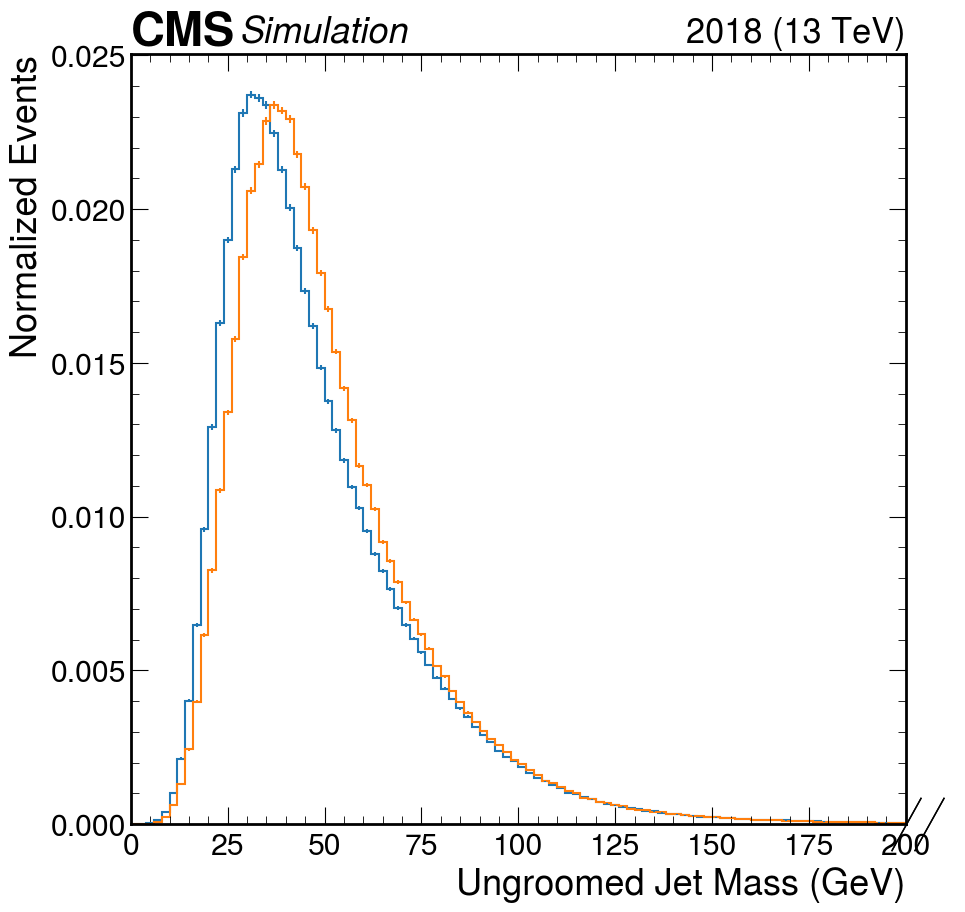

In [14]:
import mplhep as hep
hep.style.use("CMS")
output1['response_matrix_u'].project('mreco').plot(density = 1, label = 'Reconstructed Level')
output1['response_matrix_u'].project('mgen').plot(density = 1, label = 'Particle Level')
plt.xlabel("Ungroomed Jet Mass (GeV)")
plt.ylabel('Normalized Events')
plt.xlim(0,200)
hep.cms.label(year = 2018)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2ce426d960>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

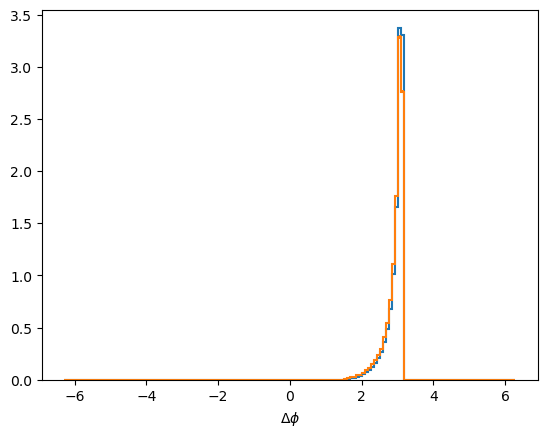

In [24]:
output1['dphi_z_jet_reco'].project('dphi').plot(density = 1)
output2['dphi_z_jet_reco'].project('dphi').plot(density = 1)

In [30]:
output1['pt_z_reco']['UL18NanoAODv9',...]

Hist(
  Regular(150, 0, 1500, name='pt', label='$p_{T}$ [GeV]'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=116604, variance=12350.7) (WeightedSum(value=116608, variance=12350.7) with flow)

In [31]:
output2['pt_z_reco']

Hist(
  StrCategory(['EGamma_UL2018', 'SingleMuon_UL2018'], growth=True, name='dataset', label='Primary dataset'),
  Regular(150, 0, 1500, name='pt', label='$p_{T}$ [GeV]'),
  StrCategory(['nominal'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=176546, variance=176546) (WeightedSum(value=176551, variance=176551) with flow)

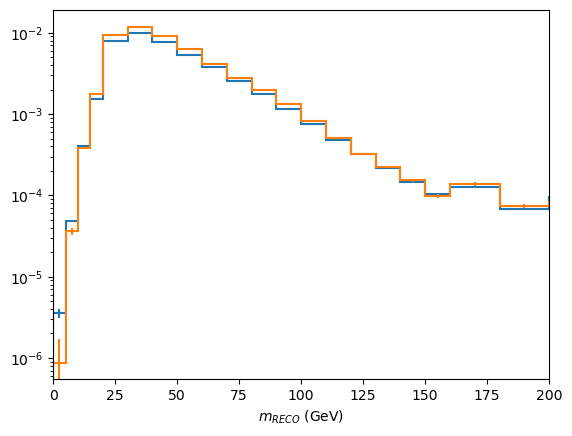

In [32]:
output1['ptjet_mjet_u_reco'].project('dataset','mreco')['UL18NanoAODv9',...].plot(density = 1)
output2['ptjet_mjet_u_reco'].project('mreco').plot(density =1)
plt.xlim(0,200)
plt.yscale('log')

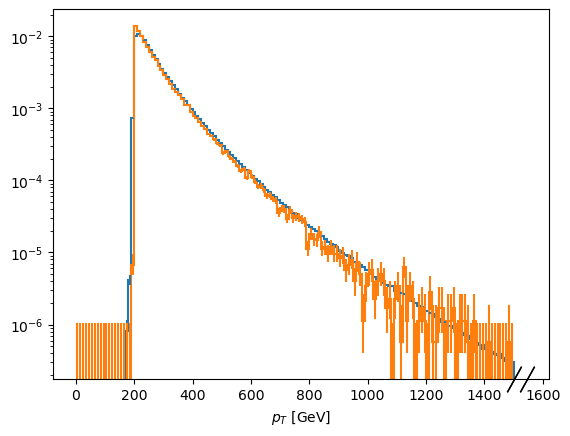

In [34]:
output1['pt_jet_reco'].project('dataset','pt')['UL18NanoAODv9',...].plot(density = 1)
output2['pt_jet_reco'].project('pt').plot(density =1)
plt.yscale('log')

In [9]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/pythia_1601.pkl'
filename2 = 'outputs/data_16.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

with open(filename2, 'rb') as f:
    output2 = pickle.load(f)

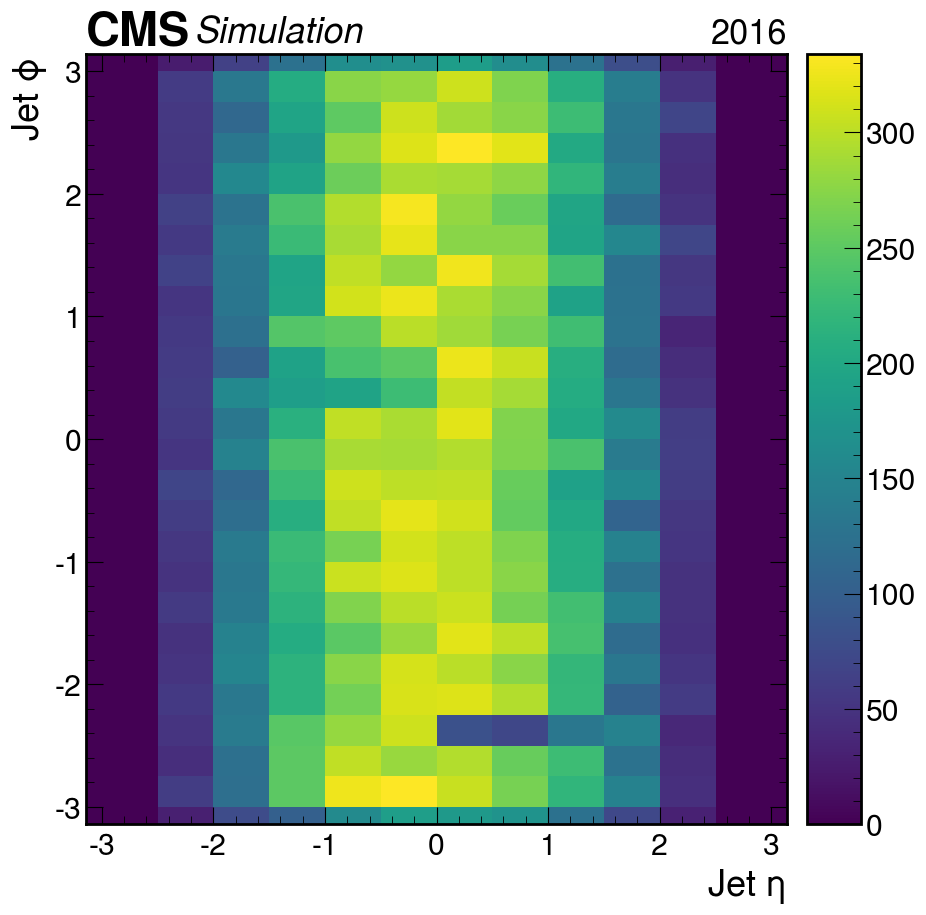

In [10]:
import mplhep as hep
hep.style.use('CMS')
titles = iter(['2016', '2016APV', '2017', '2018'])
for era in ['UL16NanoAODv9','UL16NanoAODAPVv9' ,'UL17NanoAODv9', 'UL18NanoAODv9']:
    
    output2['eta_phi_jet_reco'].project('eta','phi').plot()
    plt.xlim(-3.14,3.14)
    plt.ylim(-3.14,3.14)
    plt.xlabel(r"Jet $\eta$ ")
    plt.ylabel(r"Jet $\phi$ ")

    hep.cms.label(data = False, rlabel = '2016')
    plt.show()
    break

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f95a39a8a30>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

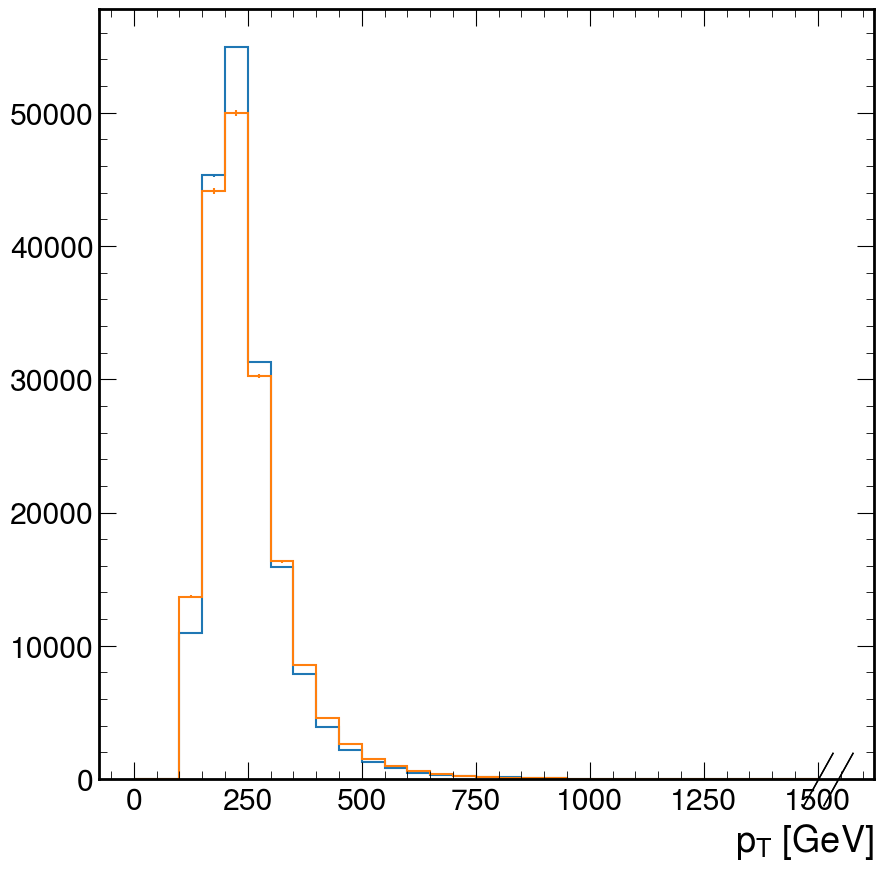

In [56]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/pythia_18_syst.pkl'
with open(filename, 'rb') as f:
    output1 = pickle.load(f)

filename = 'outputs/pythia_syst_2411.pkl'
with open(filename, 'rb') as f:
    output2 = pickle.load(f)

filename = 'outputs/data_2018_v2.pkl'
with open(filename, 'rb') as f:
    output3 = pickle.load(f)
import hist

output1['pt_z_reco'][{'systematic':'nominal'}].project('pt')[hist.rebin(5)].plot(density = False)
#output2['pt_z_reco'][{'dataset':'UL18NanoAODv9'}].project('pt')[hist.rebin(2)].plot(density = True)
output3['pt_z_reco'].project('pt')[hist.rebin(5)].plot(density = False)

In [ ]:
output1['pt_z_reco']

In [ ]:

filename = 'outputs/pythia_17_syst.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)

output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['nominal', 'puUp', 'puDown', 'elerecoUp', 'elerecoDown', 'eleidUp', 'eleidDown', 'eletrigUp', 'eletrigDown', 'murecoUp', 'murecoDown', 'muidUp', 'muidDown', 'mutrigUp', 'mutrigDown', 'pdfUp', 'pdfDown', 'q2Up', 'q2Down', 'prefiringUp', 'prefiringDown', 'JERUp', 'JERDown', 'hem'],3,:].plot()
plt.xlim(0,200)
plt.legend()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f95acc9b670>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

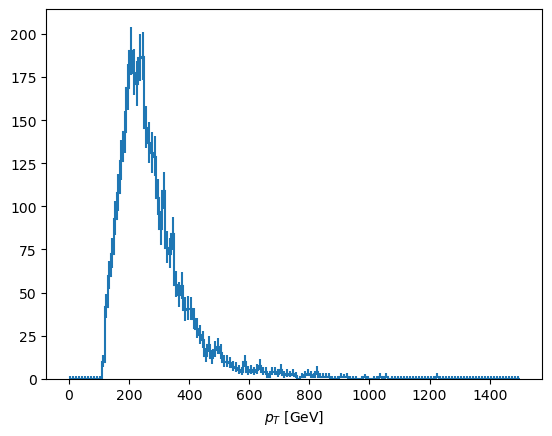

In [20]:
import pickle
import matplotlib.pyplot as plt
filename = 'outputs/test_bg_ttjets.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)


output['pt_z_reco'].project('pt').plot()

In [ ]:
output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['eleidUp'] ,:,:]

In [ ]:
398395
385310

In [ ]:
vals = output['response_matrix_u'].project('systematic','ptreco', 'mreco')[['nominal', 'eleidUp', 'eleidDown'   ],:,:].values()
plt.stairs(vals[0].flatten())
plt.stairs(vals[1].flatten())
plt.stairs(vals[2].flatten())

In [ ]:
#plt.imshow(output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(56, 56), origin  = 'lower', norm = 'log')
vals = output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(56, 56).T
for i in range(56):
    vals[i] /= vals[i].sum()
plt.imshow(vals, origin  = 'lower', norm = 'log')

In [ ]:
output['response_matrix_u'].project('ptreco', 'mreco')[2,:].plot(density = False)
output['response_matrix_u'].project('ptgen', 'mgen')[2,:].plot(density = False)
plt.xlim(0 ,120)

In [ ]:
import pickle
filename = 'outputs/pythia_v24.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)
with open('outputs/data_v24.pkl', 'rb') as f:
    output_data = pickle.load(f)

In [ ]:
import mplhep as hep
from matplotlib import gridspec
import matplotlib.pyplot as plt
hep.style.use("CMS")
h1 = output['phi_z_reco'][:,:,0].project('phi')
h2 = output_data['phi_z_reco'][:,:,0].project('phi')

h1 = h1*(h2.sum().value/h1.sum().value)
plot_ratio(h1, h2)
# fig = plt.figure(figsize=(9, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# ax1 = plt.subplot(gs[0] )

def plot_ratio(h1, h2, xlabel = r"Z candidate $\phi$"):
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax1 = plt.subplot(gs[0] )
    edges = h1.axes[0].edges
    centers = h1.axes[0].centers
    ax1.set_ylabel("Events")
    ax1.stairs( h1.values(), edges, color = 'r', label = 'MC')
    ax1.stairs( h2.values(), edges, color = 'black', label = 'Data')
    ax1.errorbar(  centers, h1.values(), h1.variances()**0.5, fmt = ' ', color = 'r' ,   )
    ax1.errorbar(  centers, h2.values(), h2.variances()**0.5, fmt = ' ', color = 'black' ,   )
    ax1.legend()
    hep.cms.label("Preliminary", data = True)
    ax2 = plt.subplot(gs[1] )
    error_ratio = (h1.values()/h2.values()) * np.sqrt( h1.variances()/(h1.values()**2) + h2.variances()/(h2.values()**2) ) 
    ax2.errorbar(centers, h1.values()/h2.values(), error_ratio, fmt = 'k o' )
    ax2.set_ylabel("MC/Data")
    ax2.set_xlabel(xlabel)
    ax2.set_ylim(0.5, 1.5)
plot_ratio(h1, h2)

In [ ]:
h1 = output_pythia['m_z_reco'][:,:,0].project('mass')
h2 = output_data['m_z_reco'][:,:,0].project('mass')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Z candidate Mass (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5, 1.5)

In [ ]:
h1 = output['eta_z_reco'][:,:,0].project('eta')
h2 = output_data['eta_z_reco'][:,:,0].project('eta')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = r"Z candidate $\eta$ (GeV)"
plot_ratio(h1, h2, xlabel)

In [ ]:
h1 = output['pt_z_reco'][:,:,0].project('pt')
h2 = output_data['pt_z_reco'][:,:,0].project('pt')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Z candidate $p_{T}$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['pt_jet_reco'][:,:,0].project('pt')
h2 = output_data['pt_jet_reco'][:,:,0].project('pt')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = "Jet $p_{T}$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['eta_jet_reco'][:,:,0].project('eta')
h2 = output_data['eta_jet_reco'][:,:,0].project('eta')

h1 = h1*(h2.sum().value/h1.sum().value)

xlabel = r"Jet $\eta$ (GeV)"
plot_ratio(h1, h2, xlabel)
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['phi_jet_reco'][:,:,0].project('phi')
h2 = output_data['phi_jet_reco'][:,:,0].project('phi')

h1 = h1*(h2.sum().value/h1.sum().value)

plot_ratio(h1, h2, r"Jet $\phi$")
plt.ylim(0.5,1.5)

In [ ]:
h1 = output['m_jet_reco'][:,:,0].project('mreco')[:13]
h2 = output_data['m_jet_reco'][:,:,0].project('mreco')[:13]

h1 = h1*(h2.sum().value/h1.sum().value)
def plot_ratio(h1, h2, xlabel = r"Z candidate $\phi$"):
    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax1 = plt.subplot(gs[0] )
    edges = h1.axes[0].edges
    centers = h1.axes[0].centers
    ax1.set_ylabel("Events")
    ax1.stairs( h1.values(), edges, color = 'r', label = 'MC')
    ax1.stairs( h2.values(), edges, color = 'black', label = 'Data')
    ax1.errorbar(  centers, h1.values(), h1.variances()**0.5, fmt = ' ', color = 'r' ,   )
    ax1.errorbar(  centers, h2.values(), h2.variances()**0.5, fmt = ' ', color = 'black' ,   )
    ax1.legend()
    hep.cms.label("Preliminary", data = True)
    ax2 = plt.subplot(gs[1] )
    error_ratio = (h1.values()/h2.values()) * np.sqrt( h1.variances()/(h1.values()**2) + h2.variances()/(h2.values()**2) ) 
    ax2.errorbar(centers, h1.values()/h2.values(), error_ratio, fmt = 'k o' )
    ax2.set_ylabel("MC/Data")
    ax2.set_xlabel(xlabel)
    ax2.set_ylim(0.5,1.5)
plot_ratio(h1, h2, r"Jet Ungroomd Mass (GeV)")


In [ ]:
output['m_z_reco'][:,:,0].project('mass').plot(density = True)
output_data['m_z_reco'][:,:,0].project('mass').plot(density = True)

In [ ]:
output['phi_jet_reco'][:,:,0].plot()

In [ ]:
import hist
for i in range(1,5):
    output['response_matrix_g'].project('ptgen', 'mgen')[i, :6].plot(binwnorm = 1)
import matplotlib.pyplot as plt
plt.yscale('log')

In [ ]:
import hist
for i in range(1,5):
    output['ptjet_mjet_g_reco'].project('ptreco', 'mreco')[i, :13][hist.rebin(2)].plot(binwnorm = 1)
import matplotlib.pyplot as plt
plt.yscale('log')

In [ ]:
sumw = np.array([250310782, 225886526.625, 213643613.125, 250987412.875])
lumi = np.array([19.52, 59.83, 41.48,  16.81])
sf = lumi*1000*5.036/sumw
print(sf)

In [ ]:
h1 = output['response_matrix_g']
for i in range(4):
    h1.view(flow = True)[i] *= sf[i]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(h1.project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(70, 35), norm = 'log')

In [ ]:
import pickle
filename = 'outputs/herwig_v20_test.pkl'
with open(filename, 'rb') as f:
    output = pickle.load(f)

import pickle
filename = 'outputs/gen_mbins_2times_nosyst_v4.pkl'
with open(filename, 'rb') as f:
    output2 = pickle.load(f)

import pickle
filename = 'outputs/reco_mbins_2times_syst_v3.pkl'
with open(filename, 'rb') as f:
    output3 = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
output["total_weight"].plot()
print(output["total_weight"].sum())
plt.xlim(8,9)

In [ ]:
output['response_matrix_g'][{'systematic':'herwig'}].sum()

In [ ]:
output['response_matrix_u']

In [ ]:
output['fakes'].project('ptreco','mreco').values()[1]

In [ ]:
import matplotlib.pyplot as plt
output['mz_gen'].project('mass').plot()

plt.xlim(0,200)

In [ ]:
output3['ptjet_mjet_g_reco'].project('mreco')

In [ ]:
output['response_matrix_g']

In [ ]:
output['response_matrix_g'].project('mreco').plot(density = False)
output2['response_matrix_g'].project('mreco').plot(density = False)
output3['ptjet_mjet_g_reco'].project('mreco').plot(density = False)
plt.xlim(0,100)

In [ ]:
output['mz_gen']

In [ ]:
output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.log(output['response_matrix_u'].project('ptreco', 'mreco', 'ptgen', 'mgen').values().reshape(70,35).T))

In [ ]:
output.keys()

In [ ]:
from coffea.lookup_tools.dense_lookup import dense_lookup
a = uproot.open("correctionFiles/eleSF/egammaEffi_EGM2D.root")
histobj = a['EGamma_SF2D;1'].to_hist()
corr = dense_lookup(histobj.values(), [ax.edges for ax in histobj.axes])
print(corr)

In [ ]:
sfhist = hist.Hist(*histobj.axes, data=histobj.values())
sfhist.plot2d()

In [ ]:
corr(ak.Array([-1.5,0.3]), ak.Array([30,50]))

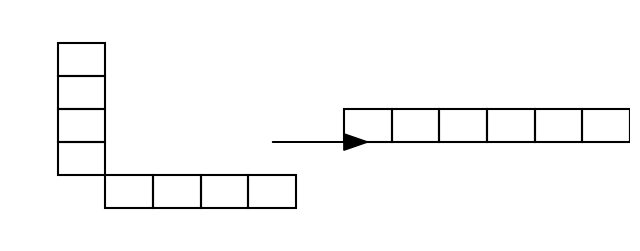

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))

# Define coordinates for 2D distribution (left side)
x2d = [0, 0, 0, 0, 1, 2, 3, 4]
y2d = [4, 3, 2, 1, 0, 0, 0, 0]

# Define coordinates for 1D transformation (right side)
x1d = np.arange(8) + 6  # Shift to the right side
y1d = [2] * 8  # Align all on a single axis

# Draw squares for 2D representation
for x, y in zip(x2d, y2d):
    rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

# Draw squares for 1D representation
for x, y in zip(x1d, y1d):
    rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

# Draw an arrow indicating transformation
ax.arrow(4.5, 2, 1.5, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1, 12)
ax.set_ylim(-1, 6)
ax.set_frame_on(False)

# Display the plot
plt.show()
